#LightGBM

In [ ]:
pip install joblib

## 1. Functions


---
Adjust "suffixes_to_drop = [".1", ".2", "True WTI_Returns", 'Date']" in "sort_columns_descending"


In [ ]:
import pandas as pd
run_models= []

# ES quantiles of interest
ES_quantiles = [0.01, 0.025, 0.05, 0.95, 0.975, 0.99]
p = 5  # 'p' defined as per requirement

# Create a list to store the quantiles
quantiles = []

for es in ES_quantiles:
    # For ES values less than 0.5, we calculate and append in descending order
    if es < 0.5:
        new_quantiles = [es - (es * i / p) for i in range(p)]
    # For ES values greater than or equal to 0.5, we calculate and append in ascending order
    else:
        new_quantiles = [es] + [es + ((1 - es) * i / p) for i in range(1, p)]
    quantiles.extend(new_quantiles)

# Format to 3 decimal places
quantiles = [f"{q:.3f}" for q in quantiles]


# Function to clean and normalize column names
def remove_suffix(input_string, suffix):
    # Check if the string ends with the specified suffix
    if input_string.endswith(suffix):
        # Slice the string to remove the suffix
        return input_string[:-len(suffix)]
    if input_string.startswith(suffix):
        return input_string[len(suffix):]
    return input_string

# Function to sort columns in correct order
def sort_columns_descending(df):

    # Remove suffixes from column names
    df1 = df
    # Specify the list of suffixes you want to filter out
    suffixes_to_drop = [".1", ".2", "True WTI_Returns", 'Date']  # Add more suffixes as needed

    # Filter out columns ending with the specified suffixes
    columns_to_drop = [col for col in df1.columns if any(col.endswith(suffix) for suffix in suffixes_to_drop)]

    # Drop the filtered columns
    df1 = df1.drop(columns=columns_to_drop)

    #columns_to_sort = [col for col in df.columns if not (col.endswith(".1") or col.endswith(".2"))]
    columns_to_sort = set(df1.columns)

    # Sort the selected columns in descending order based on their numeric values
    sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[-1]), reverse=True)

    # Create a list of all columns, including the last two
    #all_columns = sorted_columns + df.columns[-2:].tolist()

    # Return the DataFrame with the columns sorted
    return df1[sorted_columns]


# Function to ensure no quantile crossing
def ensure_non_crossing(df):
    # List of quantile columns in the order they appear in the dataset
    quantile_columns = [col for col in df if col.startswith("Quantile_")]

    # Iterate through each row of the dataframe
    for index, row in df.iterrows():
        # Iterate through the quantile columns except for the last one
        for i in range(len(quantile_columns) - 1):

            current_quantile = quantile_columns[i]
            current_quantile_1 = current_quantile

            next_quantile = quantile_columns[i + 1]
            next_quantile_1 = next_quantile

            current_quantile_1 = remove_suffix(current_quantile_1, ".1")
            current_quantile_1 = remove_suffix(current_quantile_1, ".2")
            current_quantile_1 = remove_suffix(current_quantile_1, "Quantile_")
            next_quantile_1 = remove_suffix(next_quantile_1,".1")
            next_quantile_1 = remove_suffix(next_quantile_1,".2")
            next_quantile_1 = remove_suffix(next_quantile_1, "Quantile_")

            current_quantile_value = float(current_quantile_1)
            next_quantile_value = float(next_quantile_1)
            # Determine the direction of adjustment based on the quantile value from the column name
            a = 0
            if current_quantile_value == next_quantile_value:
              a+=1
              print(a)
            if current_quantile_value <= 0.5:

                if (df.at[index, current_quantile] < df.at[index, next_quantile]):
                    df.at[index, next_quantile] = df.at[index, current_quantile] - 0.0001

        for k in range(len(quantile_columns)-1, 0, -1):

          current_quantile = quantile_columns[k]
          current_quantile_1 = current_quantile

          next_quantile = quantile_columns[k - 1]
          next_quantile_1 = next_quantile

          current_quantile_1 = remove_suffix(current_quantile_1, ".1")
          current_quantile_1 = remove_suffix(current_quantile_1, ".2")
          current_quantile_1 = remove_suffix(current_quantile_1, "Quantile_")
          next_quantile_1 = remove_suffix(next_quantile_1,".1")
          next_quantile_1 = remove_suffix(next_quantile_1,".2")
          next_quantile_1 = remove_suffix(next_quantile_1, "Quantile_")

          current_quantile_value = float(current_quantile_1)
          next_quantile_value = float(next_quantile_1)
          if current_quantile_value >= 0.5:

            if (df.at[index, current_quantile] > df.at[index, next_quantile]):

              df.at[index, next_quantile] = df.at[index, current_quantile] + 0.0001

    return df

# Update the columns in df2 by overwriting using the corresponding value from df1
def overwrite_columns(df1, df2):
    # Get the column names to be overwritten (excluding the last two columns)
    df2.columns = [col.rstrip(".1") if col.endswith(".1") else col for col in df2.columns]
    df2.columns = [col.rstrip(".2") if col.endswith(".2") else col for col in df2.columns]
    columns_to_overwrite = df2.columns[:-2]

    # Iterate over the columns to be overwritten
    for column in columns_to_overwrite:
        # Check if the column exists in df2
        if column in df2.columns:
            # Overwrite the corresponding column in df2 with the column from df1
            df2[column] = df1[column]
        else:
            print(f"Column '{column}' not found in DataFrame 2. Skipped.")

    return df2

## 2. Model specification and forecasting

---
Adjust hyperparameters in "train_and_predict_..." as needed (not necessary)


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed  # For parallel processing

def train_and_predict_lgb(X_train, y_train, X_val, y_val, X_test, quantile_alpha):
    """Trains an LGBMRegressor model for a specific quantile and predicts on test data."""
    model = LGBMRegressor(
        objective='quantile',
        alpha=quantile_alpha,
        metric='quantile',
        num_leaves=8,  # Adjust hyperparameters as needed
        learning_rate=0.01,
        n_estimators=600,
        boosting_type='gbdt',
        lambda_l2=1,
        random_state=72
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )
    return model.predict(X_test)[0]

def run_quantile_regression_rolling_window(file_path, sheet_name, date_column, target_column, feature_columns):
    """Performs quantile regression with LightGBM using a rolling window approach.

    Args:
        file_path (str): Path to the Excel file containing the data.
        sheet_name (str): Name of the sheet in the Excel file.
        date_column (str): Name of the column containing dates.
        target_column (str): Name of the column to be predicted (the target variable).
        feature_columns (list): List of column names to be used as features.
    """

    window_size=1500
    prediction_horizon=1

    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df[date_column] = pd.to_datetime(df[date_column], format='%Y%m%d')
    df = df.sort_values(by=date_column)
    df[f'{target_column}_lag'] = df[target_column].shift(-prediction_horizon)
    df = df.dropna()

    predictions_list = []

    for i in range(window_size, len(df) - prediction_horizon + 1, 1):
        # Data for current window and prediction horizon
        X_window = df.iloc[i - window_size:i][feature_columns]
        y_window = df.iloc[i - window_size:i][f'{target_column}_lag']

        # Train-val split (no shuffling for time series)
        X_train, X_val, y_train, y_val = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

        # Data for making predictions
        X_test = df.iloc[i + prediction_horizon - 1: i + prediction_horizon][feature_columns]
        date_current = df.iloc[i + prediction_horizon - 1][date_column]
        true_value = df.iloc[i + prediction_horizon - 1][target_column]

        # Parallel prediction for all quantiles
        window_predictions = {'Date': date_current, f'True {target_column}': true_value}
        predictions = Parallel(n_jobs=-1)(
            delayed(train_and_predict_lgb)(X_train, y_train, X_val, y_val, X_test, q) for q in quantiles
        )

        for pred, q in zip(predictions, quantiles):
            window_predictions[f'Quantile_{q}'] = pred
        predictions_list.append(window_predictions)

    # Convert to DataFrame for output
    column_order = [f"Quantile_{q}" for q in quantiles] + ["Date", f"True {target_column}"]
    predictions_df = pd.DataFrame(predictions_list)[column_order]

    # Save predictions
    feature_columns_str = '_'.join(feature_columns)
    output_path = f"{feature_columns_str}_ES_VaR_lightgbm.xlsx"
    predictions_df.to_excel(output_path, index=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    for q in quantiles:
        plt.plot(predictions_df['Date'], predictions_df[f'Quantile_{q}'], label=f'Quantile {q}')
    plt.plot(predictions_df[date_column], predictions_df[f'True {target_column}'], label=f'True {target_column}')
    plt.title(f'Quantile Predictions for {target_column}')
    plt.xlabel(date_column)
    plt.ylabel(target_column)
    #plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 3. Running all model variants


---



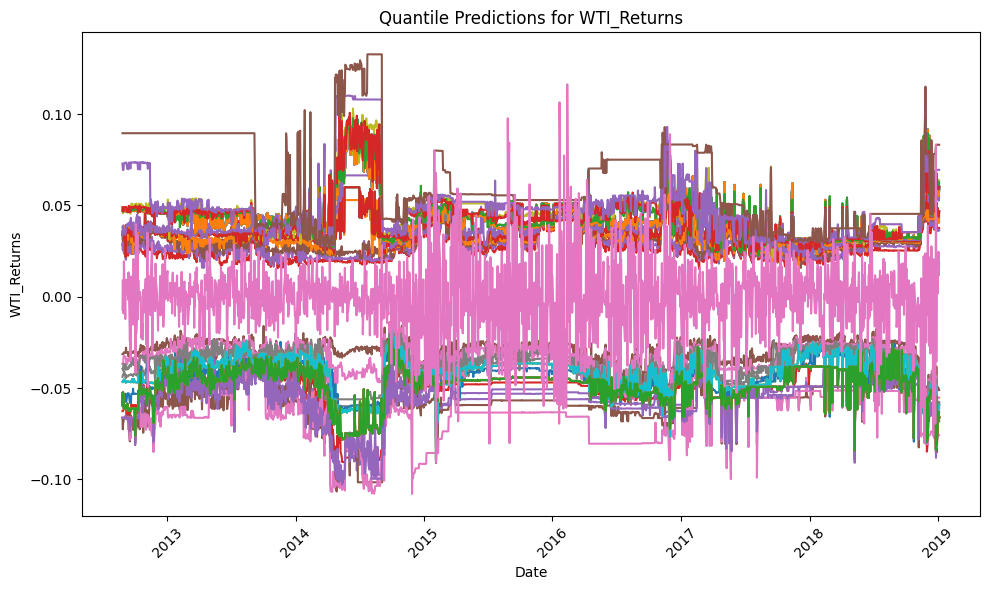

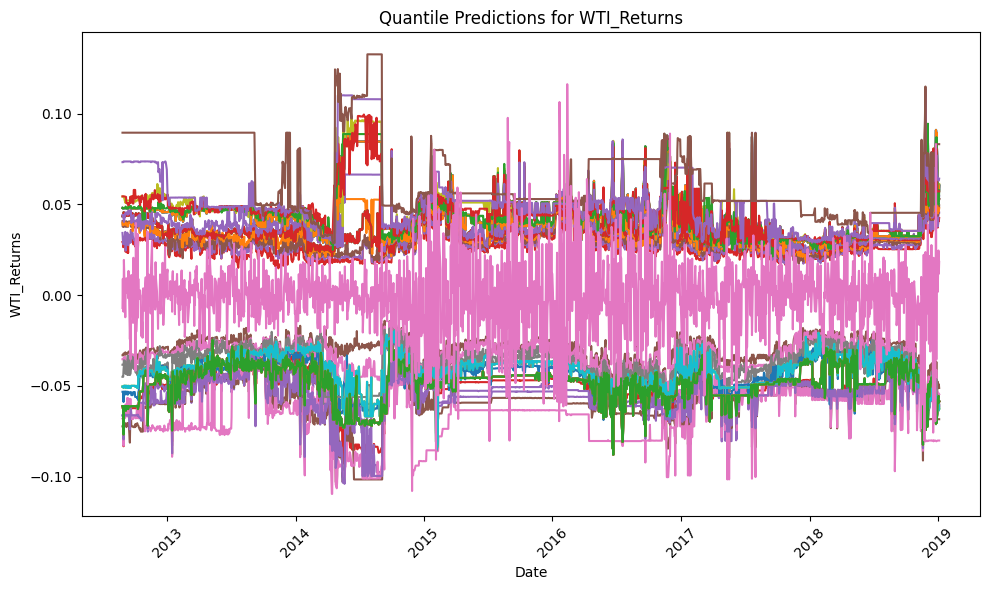

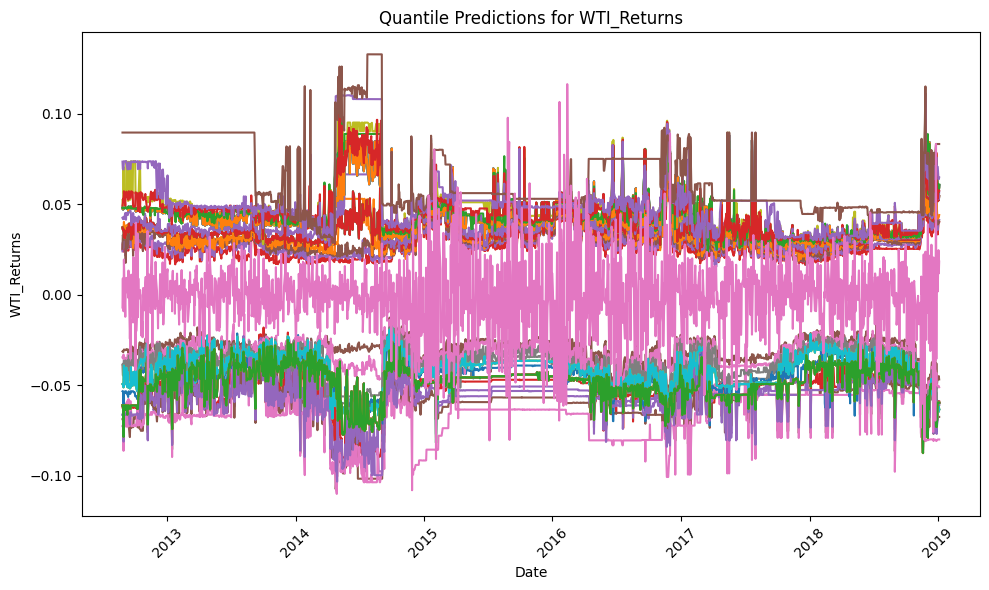

In [ ]:
# Define a list to store the output filenames
output_filenames = []

# Loop through the desired feature combinations
feature_combinations = [
    #['IV'],
    #['IV', 'IS'],
    #['IV', 'IK'],
    #['IV', 'Slope'],
    #['IV', 'IS', 'IK'],
    #['IV', 'IS', 'Slope'],
    #['IV', 'IK', 'Slope'],
    ['IV', 'IS', 'IK', 'Slope']
]

for features in feature_combinations:
  # Construct the expected output filename based on features
  filename_prefix = '_'.join(features)
  output_filename = f"{filename_prefix}_ES_VaR_lightgbm.xlsx"
  output_filenames.append(output_filename)

  # Run the quantile regression with the current feature set
  run_quantile_regression_rolling_window('WTI.xlsx', 'Sheet1', 'Date', 'WTI_Returns', features)



## 4. Handle quantile crossing


---
Specify the file of interest


In [ ]:
file_pathtest = '/content/IV_Slope_ES_VaR_lightgbm.xlsx'

# Reload the data without converters
temp_data = pd.read_excel(file_pathtest)

temp_data_ordered = sort_columns_descending(temp_data)
temp_data_corrected = ensure_non_crossing(temp_data_ordered)

# Modify column names to remove the '.1' suffix if present
temp_data.columns = [col.rstrip(".1") if col.endswith(".1") else col for col in temp_data.columns]
temp_data.columns = [col.rstrip(".2") if col.endswith(".2") else col for col in temp_data.columns]

temp_data = overwrite_columns(temp_data_corrected,temp_data)

outputname = '/content/IV_Slope_ES_VaR_CROSS_lightgbm.xlsx'
#outputname = f"{file_pathtest[:-len('.xlsx')]}_CROSS.xlsx"

temp_data.to_excel(outputname, index=False)
run_models.append(outputname)

#/content/IV_ES_VaR_lightgbm.xlsx
#/content/IV_IK_ES_VaR_lightgbm.xlsx
#/content/IV_IK_Slope_ES_VaR_lightgbm.xlsx
#/content/IV_IS_ES_VaR_lightgbm.xlsx
#/content/IV_IS_IK_ES_VaR_lightgbm.xlsx
#/content/IV_IS_IK_Slope_ES_VaR_lightgbm.xlsx
#/content/IV_IS_Slope_ES_VaR_lightgbm.xlsx
#/content/IV_Slope_ES_VaR_lightgbm.xlsx

#/content/IV_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IK_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IK_Slope_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IS_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IS_IK_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IS_IK_Slope_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_IS_Slope_ES_VaR_CROSS_lightgbm.xlsx
#/content/IV_Slope_ES_VaR_CROSS_lightgbm.xlsx

## 5. Estimate ES


---



In [ ]:
from google.colab import files

def run_ES(models):

  for i in range(0, len(models)):

    # Specify the path to your Excel file
    excel_file_path = models[i]

    # Import the Excel file and convert it to a dataframe1
    dataframe1 = pd.read_excel(excel_file_path)

    # Create an empty dataframe2
    ES_predictions = pd.DataFrame()

    print(len(dataframe1.columns))


    for i in range(0, 29, 5):  # Iterate in steps of 4 to group every 4 columns out of the first 24
    #for i in range(0, len(dataframe1.columns) - 4, 5):
        # Calculate the mean for the 1st, 2nd, 3rd, and 4th columns from index 'i'
        print(i)

        col_indices = [i, i + 1, i + 2, i + 3,i + 4]
        selected_cols = dataframe1.iloc[:, col_indices]

        col_mean = selected_cols.mean(axis=1)

        # Get the current ES quantile value for naming the column
        quantile_index = int(i / 5)  # Adjust the divisor to match the step in the loop
        if quantile_index <= len(ES_quantiles):
            col_name = f'ES_{ES_quantiles[quantile_index]}'
            ES_predictions[col_name] = col_mean
        else:
            print(f"Not enough quantiles for column set starting at index {i}")
            break  # Break the loop if there are no more quantiles for naming

    # Write dataframe2 to an Excel file
    ES_predictions['Date'] = dataframe1['Date']
    ES_predictions['True WTI_Returns'] = dataframe1['True WTI_Returns']
    #ES_predictions['Date'] = dataframe1['Date']
    #ES_predictions['True Target'] = dataframe1[target_column]

    output_file_path = excel_file_path.replace('_VaR_CROSS','')

    ES_predictions.to_excel(output_file_path, index=False)
print(run_models)

run_ES(run_models)

# Adjust based on which model variant is runned
#files.download('IV_IS_IK_Slope_ES_VaR_lightgbm.xlsx')
#files.download('IV_IS_IK_Slope_ES_VaR_CROSS_lightgbm.xlsx')
#files.download('IV_IS_IK_Slope_ES_lightgbm.xlsx')

['/content/IV_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IK_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IK_Slope_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IS_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IS_IK_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IS_IK_Slope_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_IS_Slope_ES_VaR_CROSS_lightgbm.xlsx', '/content/IV_Slope_ES_VaR_CROSS_lightgbm.xlsx']
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
32
0
5
10
15
20
25
